In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load fish data - batch1 and batch2

In [9]:
def get_data(power, day, batch, mode='tracking'):
    wkdir = '/Users/panpan/PycharmProjects/old_project/fish_llr/Processed_data/{}/extract_scale_features/'.format(mode)
    filename = '{}W-60h-{}dpf-01-batch{}.csv'.format(power, day, batch)
    df = pd.read_csv(os.path.join(wkdir, filename))
    return df

from scipy.stats import mannwhitneyu
from pingouin import mwu

def combine_df(df1, df2):
    df_features = pd.concat([df1, df2], axis=0)
    df_features['batch'] = np.concatenate([[0]*len(df1), [1]*len(df2)], axis=0)
    return df_features

# QuantileTransformer

from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer

for batch_idx in [0, 1]:
    scaler = PowerTransformer()#(output_distribution='normal')
    df_features.loc[(df_features['batch'] == batch_idx) &
                    (df_features['label'] == 0)] = scaler.fit_transform(df_features.loc[(df_features['batch'] == batch_idx) &
                                                                                        (df_features['label'] == 0)])
    df_features.loc[(df_features['batch'] == batch_idx) &
                    (df_features['label'] == 1)] = scaler.transform(df_features.loc[(df_features['batch'] == batch_idx) &
                                                                                    (df_features['label'] == 1)])


df_features.drop(['batch'], axis=1, inplace=True)
df_features['label'] = (df_features['label']>0).astype(int)
df_features['batch'] = np.concatenate([[0]*len(df1), [1]*len(df2)], axis=0)

In [10]:
from scipy.stats import normaltest, anderson,shapiro

# # batch = 1
# power = 3
# day = 5
#
# df1 = get_data(power, day, 1)
# df2 = get_data(power, day, 2)
#
# df_features = combine_df(df1, df2)
# # df_features.drop(['batch'], axis=1, inplace=True)
# # df_features['label'] = (df_features['label']>0).astype(int)
# df_features['batch'] = np.concatenate([[0]*len(df1), [1]*len(df2)], axis=0)

# # histogram for each feature
# plt.figure(figsize=(20, 10))
# for i in range(len(df_features.columns)-2):
#     plt.subplot(4, 10, i + 1)
#     # plt.hist(df_features.iloc[:, i], bins=10)
#     bins = np.linspace(df_features.iloc[:, i].min(), df_features.iloc[:, i].max(), 10)
#     plt.hist(df_features[df_features['label'] == 0][df1.columns[i]], bins=bins, color='blue', alpha=0.5)
#     plt.hist(df_features[df_features['label'] == 1][df1.columns[i]], bins=bins, color='red', alpha=0.5)
#     # normaltest
#     # res = normaltest(df_features.iloc[:, i].values)
#     # res = normaltest(df_features.loc[df_features['label'] == 0][df1.columns[i]].values)
#
#     # keep 2 decimal for pvalue
#     # plt.title('{} \n (p-value: {:.2f})'.format(df1.columns[i], res.pvalue))
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
# plt.tight_layout()


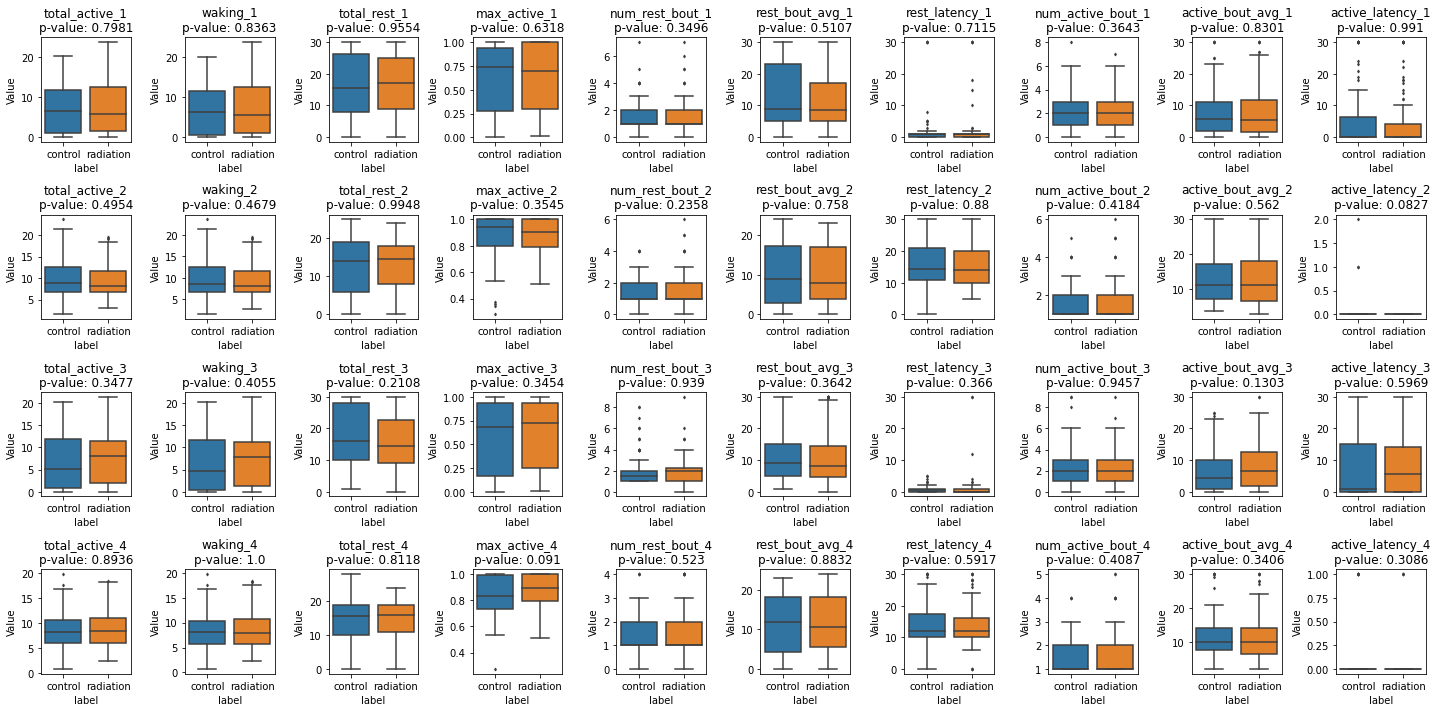

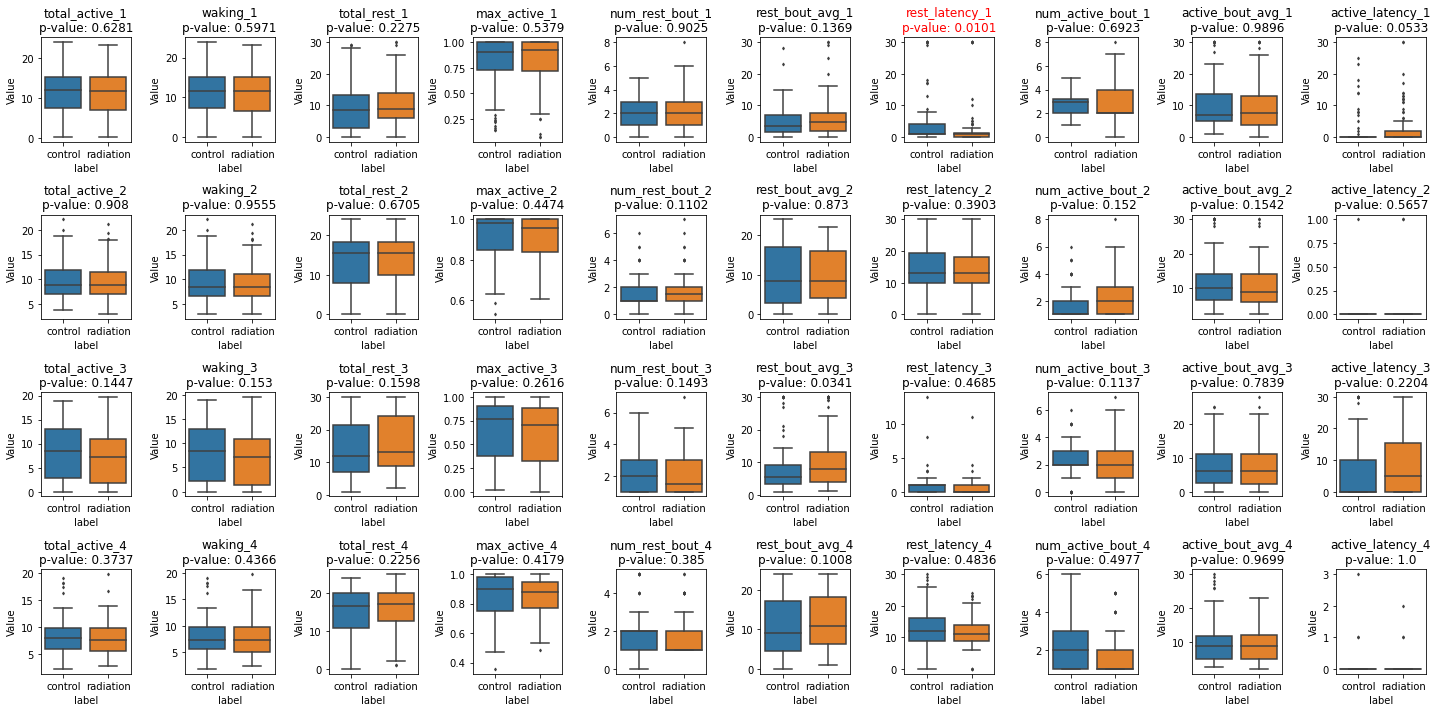

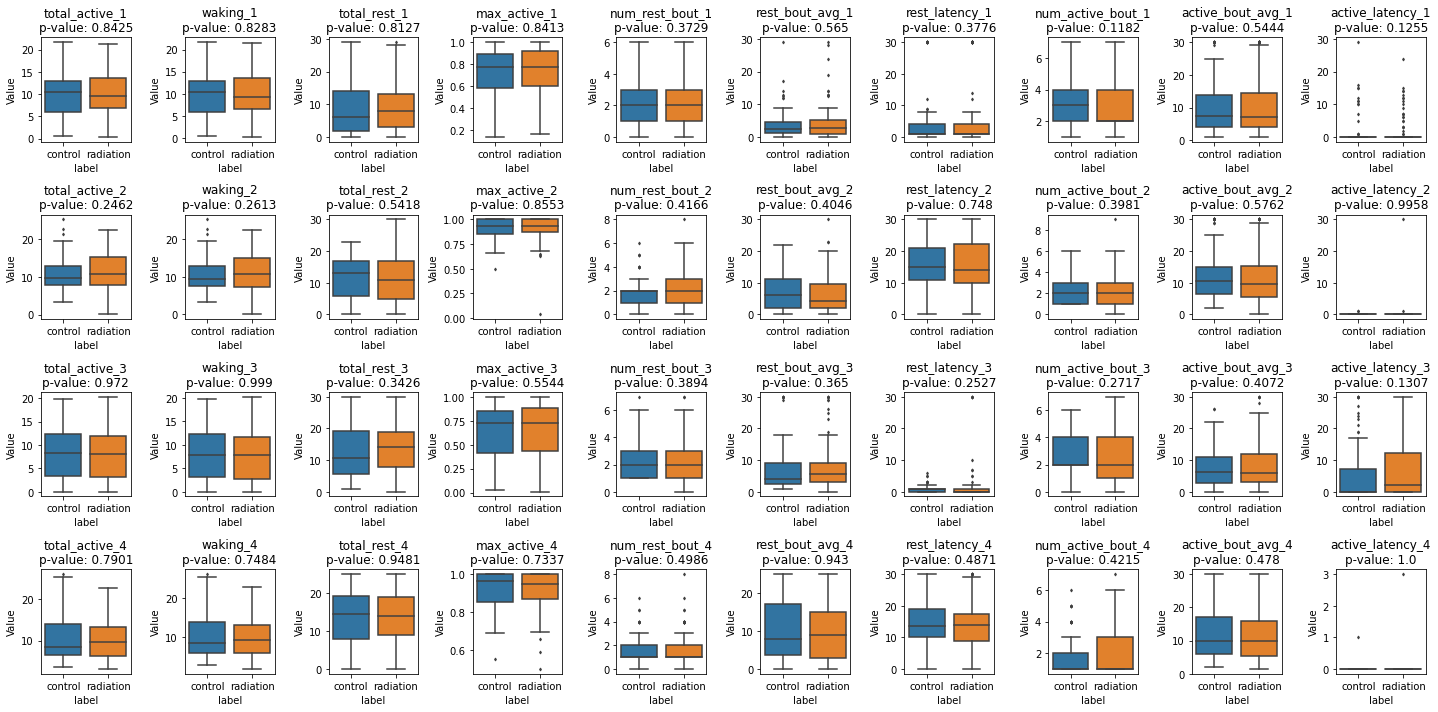

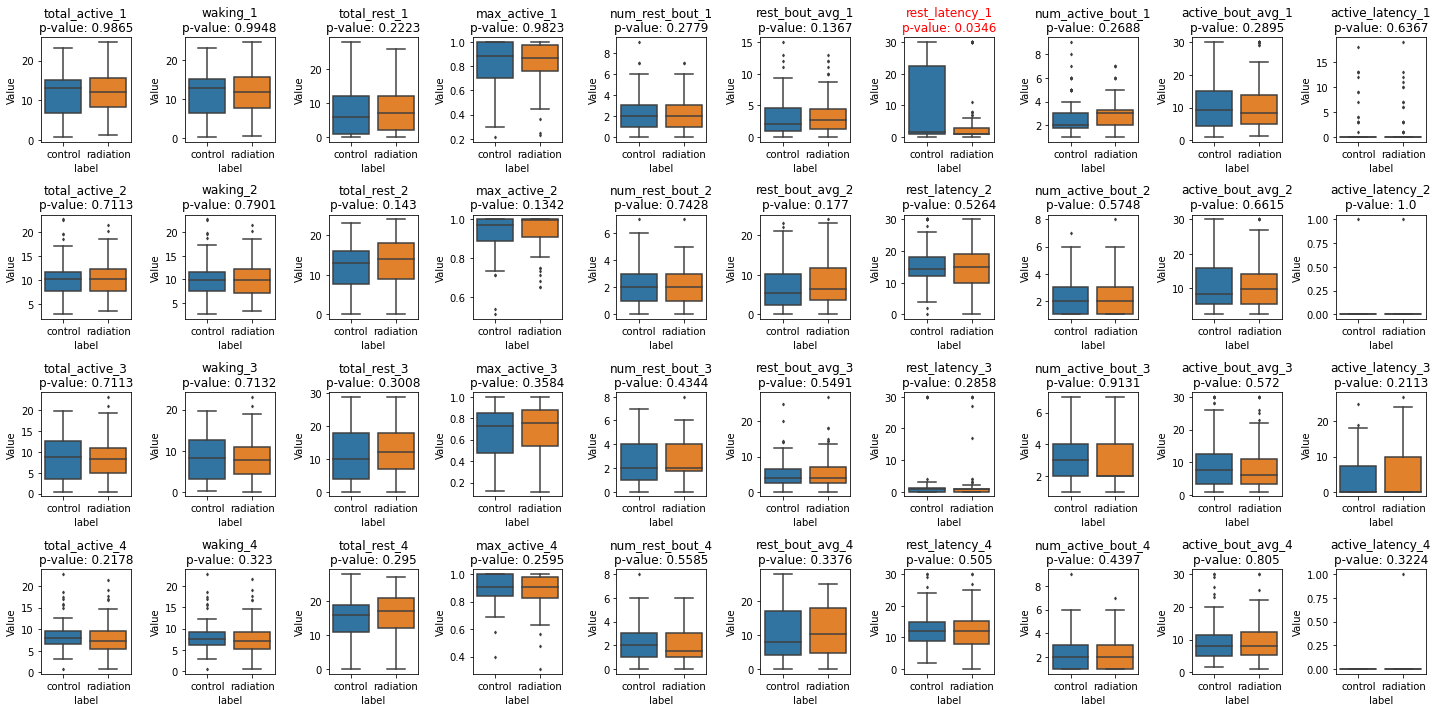

In [12]:
# from scipy.stats import mannwhitneyu

# batch = 1
mode = 'quantization'
# mode = 'tracking'
power = 5
days = [5, 6, 7, 8]

for day in days:

    df1 = get_data(power, day, 1, mode=mode)
    df2 = get_data(power, day, 2, mode=mode)

    df_features = combine_df(df1, df2)
    # df_features.drop(['batch'], axis=1, inplace=True)
    # df_features['label'] = (df_features['label']>0).astype(int)
    df_features['batch'] = np.concatenate([[0]*len(df1), [1]*len(df2)], axis=0)

    from pingouin import mwu
    plt.figure(figsize=(20, 10))
    for i in range(len(df_features.columns)-2):
        plt.subplot(4, 10, i + 1)
        sns.boxplot(x='label', y=df_features.columns[i], data=df_features, fliersize=2)
        plt.xticks([0, 1], ['control', 'radiation'])
        plt.ylabel('Value')
        # plt.yscale('symlog')

        # nonparametric mannwhitneyu test between control and radiation
        # mannwhitneyu_pvalue = mannwhitneyu(df_features.loc[df_features['label']==0, df_features.columns[i]],
        #                                df_features.loc[df_features['label']==1, df_features.columns[i]])

        res = mwu(df_features.loc[df_features['label']==0, df_features.columns[i]],
                                df_features.loc[df_features['label']==1, df_features.columns[i]])#, tail='two-sided')
        # title with color
        # if wilcoxon_pvalue[1] < 0.05:
        if (res['p-val'].values < 0.05) and (res['CLES'].values > 0.5):
            color = 'red'
        else:
            color = 'black'
        plt.title(df_features.columns[i] + '\n' + 'p-value: '+ str(res['p-val'].values[0].round(4)),  color=color)

        plt.tight_layout()
    figure_dir = '/Users/panpan/PycharmProjects/old_project/fish_llr/Figures/{}_feature_comparison'.format(mode)
    plt.savefig(os.path.join(figure_dir, '{}W-60h-{}dpf-boxplot.png'.format(power, day)))

In [69]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import RobustScaler, PowerTransformer
# def matching_control(df):
#     # control dataframe
#     df_ctrl = df[df['label']==0].drop(['label'], axis=1)
#     df_rad = df[df['label']==1].drop(['label'], axis=1)
#     # robust scaler
#     scaler = PowerTransformer()
#     df_ctrl = scaler.fit_transform(df_ctrl)
#     df_rad = scaler.transform(df_rad)
#
#     df_ctrl = pd.DataFrame(df_ctrl, columns=df.drop('label', axis=1).columns)
#     df_rad = pd.DataFrame(df_rad, columns=df.drop('label', axis=1).columns)
#
#     df_ctrl['label'] = 0
#     df_rad['label'] = 1
#
#     return df_rad, df_ctrl
#     '''
#     X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=test_size, random_state=42)
#     # transform
#
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#
#     X_train = pd.DataFrame(X_train, columns=df.drop('label', axis=1).columns)
#     X_test = pd.DataFrame(X_test, columns=df.drop('label', axis=1).columns)
#     return X_train, X_test, y_train, y_test
#     '''
#
# # df1_train, df1_test = df_split(df1)
# # X_train_1, X_test_1, y_train_1, y_test_1 = df_split(df1)
# # X_train_2, X_test_2, y_train_2, y_test_2 = df_split(df2)
# df_rad1, df_ctrl1 = matching_control(df1)
# df_rad2, df_ctrl2 = matching_control(df2)

/opt/miniconda3/envs/RL_health/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [70]:
# # correlation matrix for df_rad_scaled and df_ctrl_scaled,
#
# plt.figure(figsize=(20, 20))
# corr_batch1 = df_rad1.corr()
# corr_batch2 = df_rad2.corr()
# # visualize with two subplots
# sns.heatmap(corr_batch1, annot=False, cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=plt.subplot(121))
# plt.title('Correlation matrix for batch1 larvae')
# sns.heatmap(corr_batch2, annot=False, cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=plt.subplot(122))
# plt.title('Correlation matrix for batch2 larvae')
# plt.tight_layout()

# Comparison with classifiers

In [13]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, permutation_test_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd


def clf(data, label, case='SVM'):
    if case == 'SVM':
        steps = [('scaler', MinMaxScaler()), ('SVM', SVC())]
        pip = Pipeline(steps)
        param_grid = [{'SVM__C': np.logspace(-3, 3, 7),
                       'SVM__gamma': np.logspace(-3, 0, 4)}]

    elif case == 'KNN':
        steps = [('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())]
        pip = Pipeline(steps)
        param_grid = [{'knn__n_neighbors': np.arange(1, 10)}]

    elif case == 'NB':
        steps = [('scaler', MinMaxScaler()), ('NB', GaussianNB())]
        pip = Pipeline(steps)
        # permutation test
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
        acc, _, pvalue = permutation_test_score(pip, data, label, cv=cv, n_permutations=500, n_jobs=-1,
                                                random_state=1, verbose=0, scoring=('balanced_accuracy'))
        return acc, pvalue

    gd_sr = GridSearchCV(pip, param_grid=param_grid, scoring='balanced_accuracy', cv=5, n_jobs=-1)
    gd_sr.fit(data, label)
    params = gd_sr.best_params_

    if case == 'SVM':
        best_C = params['SVM__C']
        best_gamma = params['SVM__gamma']
        # best model
        model = SVC(C=best_C, gamma=best_gamma)
    elif case == 'KNN':
        n_neighbors = params['knn__n_neighbors']
        model = KNeighborsClassifier(n_neighbors=n_neighbors)

    # permutation test
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
    acc, _, pvalue = permutation_test_score(model, data, label, cv=cv, n_permutations=500, n_jobs=-1,
                                            random_state=1, verbose=0, scoring=('balanced_accuracy'))
    return acc, pvalue

In [32]:
# classification using features and SVM
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

from scipy.stats import kruskal, mannwhitneyu

# boxplot for each features
# histogram for each feature

# mode = 'tracking'
mode = 'quantization'
powers = [5, 3, 1.2, 0]
days = [5, 6, 7, 8]
batches = [1, 2]

power_list = []
day_list = []
acc_list = []
pvalue_list = []
case_list = []
cases = ['SVM', 'KNN', 'NB']
metrics = ['total_active_1', 'waking_1', 'max_active_1', 'num_rest_bout_1','num_active_bout_1', 'active_bout_avg_1',
            'total_active_3', 'waking_3', 'max_active_3', 'num_rest_bout_3','num_active_bout_3', 'active_bout_avg_3']
#
# metrics = ['total_active_1', 'waking_1', 'total_rest_1', 'max_active_1',
#        'num_rest_bout_1', 'rest_bout_avg_1', 'rest_latency_1',
#        'num_active_bout_1', 'active_bout_avg_1', 'active_latency_1',
#        'total_active_2', 'waking_2', 'total_rest_2', 'max_active_2',
#        'num_rest_bout_2', 'rest_bout_avg_2', 'rest_latency_2',
#        'num_active_bout_2', 'active_bout_avg_2', 'active_latency_2',
#        'total_active_3', 'waking_3', 'total_rest_3', 'max_active_3',
#        'num_rest_bout_3', 'rest_bout_avg_3', 'rest_latency_3',
#        'num_active_bout_3', 'active_bout_avg_3', 'active_latency_3',
#        'total_active_4', 'waking_4', 'total_rest_4', 'max_active_4',
#        'num_rest_bout_4', 'rest_bout_avg_4', 'rest_latency_4',
#        'num_active_bout_4', 'active_bout_avg_4', 'active_latency_4']

for case in cases:
    for power in powers:
        for day in days:
            df1 = get_data(power, day, 1, mode=mode)
            df2 = get_data(power, day, 2, mode=mode)
            df = combine_df(df1, df2)
            # TODO: remove nan rows
            df = df.dropna()
            X = df[[col for col in df.columns if col in metrics]]
            y = df['label']
            acc, pvalue = clf(X, y, case=case)
            case_list.append(case)
            power_list.append(power)
            day_list.append(day)
            acc_list.append(acc)
            pvalue_list.append(pvalue)

df = pd.DataFrame(data=dict(power=power_list, day=day_list, acc=acc_list, pvalue=pvalue_list, classifier=case_list))
df.to_csv('/Users/panpan/PycharmProjects/old_project/fish_llr/Processed_data/ML_{}_subset_acc.csv'.format(mode))

In [33]:
df.sort_values(by=['power', 'day', 'classifier'], inplace=True)

In [31]:
df

,power,day,acc,pvalue,classifier
28,0.0,5,0.466579,0.820359,KNN
44,0.0,5,0.513632,0.161677,NB
12,0.0,5,0.496579,0.610778,SVM
29,0.0,6,0.478249,0.734531,KNN
45,0.0,6,0.500877,0.499002,NB
13,0.0,6,0.505722,0.033932,SVM
30,0.0,7,0.538342,0.141717,KNN
46,0.0,7,0.489921,0.750499,NB
14,0.0,7,0.503526,0.303393,SVM
31,0.0,8,0.506272,0.419162,KNN


In [31]:
X.columns

Index(['total_active_1', 'waking_1', 'total_rest_1', 'max_active_1',
       'num_rest_bout_1', 'rest_bout_avg_1', 'rest_latency_1',
       'num_active_bout_1', 'active_bout_avg_1', 'active_latency_1',
       'total_active_2', 'waking_2', 'total_rest_2', 'max_active_2',
       'num_rest_bout_2', 'rest_bout_avg_2', 'rest_latency_2',
       'num_active_bout_2', 'active_bout_avg_2', 'active_latency_2',
       'total_active_3', 'waking_3', 'total_rest_3', 'max_active_3',
       'num_rest_bout_3', 'rest_bout_avg_3', 'rest_latency_3',
       'num_active_bout_3', 'active_bout_avg_3', 'active_latency_3',
       'total_active_4', 'waking_4', 'total_rest_4', 'max_active_4',
       'num_rest_bout_4', 'rest_bout_avg_4', 'rest_latency_4',
       'num_active_bout_4', 'active_bout_avg_4', 'active_latency_4'],
      dtype='object')

In [28]:
df

,power,day,acc,pvalue,classifier
12,0.0,5,0.474211,0.784431,KNN
13,0.0,6,0.478249,0.734531,KNN
14,0.0,7,0.538342,0.141717,KNN
15,0.0,8,0.508351,0.397206,KNN
16,1.2,5,0.569358,0.033932,KNN
17,1.2,6,0.562943,0.039920,KNN
18,1.2,7,0.491020,0.600798,KNN
19,1.2,8,0.525711,0.227545,KNN
20,3.0,5,0.609661,0.001996,KNN
21,3.0,6,0.562093,0.037924,KNN
